# Cycle Simulation

A cycle simulation is an execution of WRF-Hydro that takes place at different times. At these different times there may be different restart and forcing files, but most other properties of the run stay the same. Examples are a "forecast" or an "analysis cycle". 

The parlance/jargon we adopt:  
  * A "cycle" (simulation) has "casts". Casts are individual simulations that comprise a group, the group is the cycle.  
  * cast:cycle as member:ensemble (covered in the ensemble simulation)

From `help(wrfhydropy.CycleSimulation)`:
```
Class for a WRF-Hydro CycleSimulation object. The Cycle Simulation object is used to
orchestrate a set of 'N' WRF-Hydro simulations, referred to as 'casts', which only differ
in their 1) restart times and 2) their forcings.
```

I keep the verbiage to a minimum in this example. Please refer to the first example for gory details.

## Preliminary

In [1]:
import datetime
import os
import pathlib
import pickle
import subprocess
import sys
import wrfhydropy

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/dask/config.py:131: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


## User Configuration
This section should be all you need to tailor to your own machine.

In [2]:
model_repo = pathlib.Path('/glade/u/home/jamesmcc/WRF_Hydro/wrf_hydro_nwm_public')
experiment_dir = pathlib.Path('/glade/scratch/jamesmcc/wrfhydropy_cycle_example')
if not experiment_dir.exists():
    os.mkdir(str(experiment_dir))
os.chdir(str(experiment_dir))

## Simulation Object
First, we build the simulation that serves as the basis for the casts in the cycle.  

The domain is pulled from the cloud, just as in the first (end-to-end) example. (Note that this section will not run on a cheyenne compute node as they are not connected to the internet.)

In [3]:
domain_dir = experiment_dir / 'domain'
if not domain_dir.exists(): 
    sys.path.append(str(model_repo / 'tests/local/utils'))
    from gdrive_download import download_file_from_google_drive
    file_id = '1xFYB--zm9f8bFHESzgP5X5i7sZryQzJe'
    file_target = 'gdrive_testcase.tar.gz'
    download_file_from_google_drive(
        file_id, 
        str(experiment_dir.joinpath(file_target)))
    untar_cmd = 'tar -xf ' + file_target + '; mv example_case domain'
    subprocess.run(
        untar_cmd, 
        shell=True,
        cwd=str(experiment_dir))

In [4]:
hrldas_model_side_file = model_repo / 'trunk/NDHMS/hrldas_namelists.json'
hrldas_domain_side_file = domain_dir / 'hrldas_namelist_patches.json'
hydro_model_side_file = model_repo / 'trunk/NDHMS/hydro_namelists.json'
hydro_domain_side_file = domain_dir / 'hydro_namelist_patches.json'
compile_options_file = model_repo / 'trunk/NDHMS/compile_options.json'
config = 'nwm_ana'

In [5]:
domain = wrfhydropy.Domain(
    domain_top_dir=domain_dir,
    domain_config=config)

In [6]:
model = wrfhydropy.Model(
    model_repo / 'trunk/NDHMS',
    compiler='ifort',
    model_config=config)

In [7]:
compile_dir = experiment_dir / 'compile'
if not compile_dir.exists():
    model.compile(compile_dir)
else: 
    model = pickle.load(compile_dir.joinpath('WrfHydroModel.pkl').open('rb'))

/glade/work/jamesmcc/python_envs/368_/lib/python3.6/site-packages/wrfhydropy-0.0.18-py3.6.egg/wrfhydropy/core/model.py:193: UserWarning: /glade/scratch/jamesmcc/wrfhydropy_cycle_example/compile directory does not exist, creating
  warnings.warn(str(self.compile_dir.absolute()) + ' directory does not exist, creating')


Model successfully compiled into /glade/scratch/jamesmcc/wrfhydropy_cycle_example/compile


In [8]:
simulation = wrfhydropy.Simulation()
simulation.add(model)
simulation.add(domain)

Note that we dont need to compose or run the Simulation. 

## Cycle Object
The documentation is always a work in progress! Please provide feedback on how to continue to improve it. You'll note that the CycleSimulation documentation actually covers what would be called CycleEnsemble, but it's not described at the top, just mentioned in the arguments. 

In [9]:
help(wrfhydropy.CycleSimulation)

Help on class CycleSimulation in module wrfhydropy.core.cycle:

class CycleSimulation(builtins.object)
 |  Class for a WRF-Hydro CycleSimulation object. The Cycle Simulation object is used to
 |  orchestrate a set of 'N' WRF-Hydro simulations, referred to as 'casts', which only differ
 |  in their 1) restart times and 2) their forcings.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, init_times:list, restart_dirs:list, forcing_dirs:list=[], ncores:int=1)
 |      Instantiate a Cycle object.
 |      Args:
 |          init_times: A required list of datetime.datetime objects which specify the
 |              restart time of each cast in the cycle. (Same for deterministic
 |              and ensemble cycle simultions).
 |          restart_dirs:
 |              Deterministic: a required list of either strings or pathlib.Path objects.
 |              Ensemble: a required list of lists. The outer list is for the cycles
 |                  "casts" requested in init_times. The inner list 

To initialize (`__init__`) a CycleSimulation, there are two required arguments. The `init_times` argument is a list of times (datetimes) at which the model will restart. We will make this every 6 hours (below we'll set the job run duration to 12 hours). The second is `restart_dirs`, a list of directories where each cast is to find it's restart files. In this case we will use the previous cast (at 6 hours prior).

In [10]:
init_times = [datetime.datetime(2011, 8, 26, 0) + 
              datetime.timedelta(hours=hh) for hh in range(0, 24, 6)]
init_times

[datetime.datetime(2011, 8, 26, 0, 0),
 datetime.datetime(2011, 8, 26, 6, 0),
 datetime.datetime(2011, 8, 26, 12, 0),
 datetime.datetime(2011, 8, 26, 18, 0)]

Since the first cast has no previous cast, we just use the existing restarts at that time. 

In [11]:
restart_dirs = ['.'] + ([-6] * (len(init_times)-1))
restart_dirs

['.', -6, -6, -6]

Instantiate the CycleSimulation object with the required arguments.

In [12]:
cycle = wrfhydropy.CycleSimulation(
    init_times=init_times, restart_dirs=restart_dirs)

Now we have a CycleSimulation to which we need to add our simulation (above) and a job.

In [13]:
exe_cmd = 'mpirun -np 1 ./wrf_hydro.exe'
job_cycle = wrfhydropy.Job(
    job_id='cycle',
    exe_cmd=exe_cmd,
    model_start_time=init_times[0],
    model_end_time=init_times[0] + datetime.timedelta(hours=12),
    restart=True,
    restart_freq_hr=6,
    output_freq_hr=1)

cycle.add(simulation)
cycle.add(job_cycle)

If we consider the job "ready to go", we can compose it to disk. This compose step follows the same pattern as a Simulation. 

In [14]:
cycle_dir = experiment_dir / 'cycle'
os.mkdir(cycle_dir)
os.chdir(cycle_dir)
cycle.compose()

Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_cycle_example/cycle/cast_2011082600'
Getting domain files...
Making job directories...
Validating job input files
cycle
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_cycle_example/cycle/cast_2011082606'
Getting domain files...
Making job directories...
Validating job input files
cycle
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_cycle_example/cycle/cast_2011082612'
Getting domain files...
Making job directories...
Validating job input files
cycle
Model already compiled, copying files...
Simulation successfully composed
Composing simulation into directory:'/glade/scratch/jamesmcc/wrfhydropy_cycle_example/cycle/cast_2011082618'
Getting domain files...
Making job directories...
Validating job input files
cycle
Model alre

As with Simulation objects, this time between compose (to disk) and run is a critical point for the user to look at the runs and verify that everything is configured correctly. 

Since these cycles are dependent on each other, we can not run them in parallel. We perform a serial, interactive run here. (Other run modes will be shown in subsequent examples).

In [15]:
cycle.run()


Running job cycle: 
    Wall start time: 2020-04-08 23:18:08
    Model start time: 2011-08-26 00:00
    Model end time: 2011-08-26 12:00

Running job cycle: 
    Wall start time: 2020-04-08 23:18:15
    Model start time: 2011-08-26 06:00
    Model end time: 2011-08-26 18:00

Running job cycle: 
    Wall start time: 2020-04-08 23:18:20
    Model start time: 2011-08-26 12:00
    Model end time: 2011-08-27 00:00

Running job cycle: 
    Wall start time: 2020-04-08 23:18:27
    Model start time: 2011-08-26 18:00
    Model end time: 2011-08-27 06:00


0

## Cycle Collection
I have not yet implemented a syntactic sugar version for more complicated objects than Simulations.... so we do this the "unchained" or "old fashioned" way. 

In [16]:
chanobs_files = sorted(cycle_dir.glob('*/*CHANOBS*'))
cycle_chanobs_ds = wrfhydropy.open_whp_dataset(chanobs_files)

n_files 48


Note that the `open_whp_dataset` function handles the dimensions of the cycle and that the time **dimensions** are `lead_time` and `reference_time` and `valid_time` is a variable with those dimensions. 

In [17]:
cycle_chanobs_ds

<xarray.Dataset>
Dimensions:         (feature_id: 4, lead_time: 12, reference_time: 4)
Coordinates:
    latitude        (feature_id) float32 41.470795 41.473614 41.449814 41.40192
    longitude       (feature_id) float32 -73.76059 -73.69085 -73.73565 -73.68741
  * reference_time  (reference_time) datetime64[ns] 2011-08-26 ... 2011-08-26T18:00:00
  * feature_id      (feature_id) int32 6226948 6226964 6227008 6227150
  * lead_time       (lead_time) timedelta64[ns] 01:00:00 02:00:00 ... 12:00:00
Data variables:
    crs             (lead_time, reference_time) |S1 b'' b'' b'' ... b'' b'' b''
    order           (lead_time, reference_time, feature_id) int32 3 2 4 ... 4 4
    elevation       (lead_time, reference_time, feature_id) float32 180.48 ... 147.61
    streamflow      (lead_time, reference_time, feature_id) float32 0.16395454 ... 12.969116
    valid_time      (lead_time, reference_time) datetime64[ns] 2011-08-26T01:00:00 ... 2011-08-27T06:00:00
Attributes:
    featureType:        timeSeries
    proj4:              +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=3...
    station_dimension:  feature_id
    Conventions:        CF-1.6

## Plot
Put `valid_time` into the coordinates so that it can be plotted against.

In [18]:
cycle_chanobs_ds = cycle_chanobs_ds.set_coords('valid_time')
cycle_chanobs_ds

<xarray.Dataset>
Dimensions:         (feature_id: 4, lead_time: 12, reference_time: 4)
Coordinates:
    latitude        (feature_id) float32 41.470795 41.473614 41.449814 41.40192
    longitude       (feature_id) float32 -73.76059 -73.69085 -73.73565 -73.68741
  * reference_time  (reference_time) datetime64[ns] 2011-08-26 ... 2011-08-26T18:00:00
  * feature_id      (feature_id) int32 6226948 6226964 6227008 6227150
  * lead_time       (lead_time) timedelta64[ns] 01:00:00 02:00:00 ... 12:00:00
    valid_time      (lead_time, reference_time) datetime64[ns] 2011-08-26T01:00:00 ... 2011-08-27T06:00:00
Data variables:
    crs             (lead_time, reference_time) |S1 b'' b'' b'' ... b'' b'' b''
    order           (lead_time, reference_time, feature_id) int32 3 2 4 ... 4 4
    elevation       (lead_time, reference_time, feature_id) float32 180.48 ... 147.61
    streamflow      (lead_time, reference_time, feature_id) float32 0.16395454 ... 12.969116
Attributes:
    featureType:        timeSeries
    proj4:              +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1=3...
    station_dimension:  feature_id
    Conventions:        CF-1.6

Do the easiest plotting thing possible.

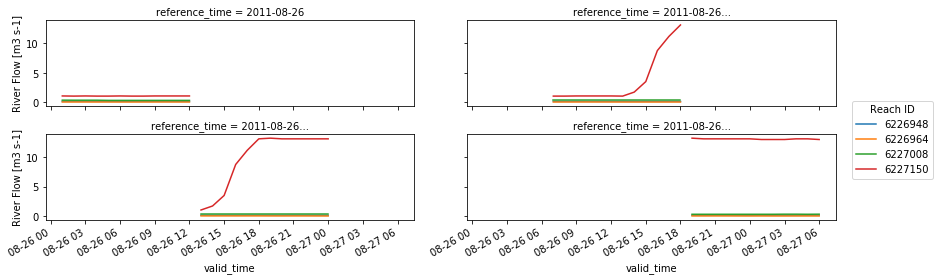

In [20]:
(cycle_chanobs_ds.streamflow.plot
    .line(x='valid_time', col='reference_time', hue='feature_id', 
          col_wrap=2,
          figsize=(12, 4)))